In [28]:
import Pkg
Pkg.pkg"activate ."

# Growth 

## Logistic growth

$$
G(B_i) = 1 - \frac{B_i}{K}
$$

Where $K$ is species carrying capacity. 

### With Julia

In [1]:
Pkg.add("ParameterizedFunctions")
using DifferentialEquations, ParameterizedFunctions, Plots

 Resolving package versions...
  Updating `~/.julia/Project.toml`
 [no changes]
  Updating `~/.julia/Manifest.toml`
 [no changes]


In [2]:
# Logistic growth

g = @ode_def begin
    db = r * (1 - (b / K)) * b
end r K

#361 (generic function with 2 methods)

In [3]:
b0 = [0.001]
tspan = (0.0, 15.0)
p = [1.0, 5.0]

prob = ODEProblem(g,b0,tspan,p)
sol = solve(prob)

retcode: Success
Interpolation: 3rd order Hermite
t: 20-element Array{Float64,1}:
  0.0                
  0.11487443084457959
  0.3983443952031699 
  0.7756934567302822 
  1.226188687832575  
  1.7576261224950298 
  2.359295877774129  
  3.028569726963454  
  3.7586590175023638 
  4.545033938634456  
  5.383463441386821  
  6.2725869053840775 
  7.215497928668885  
  8.221834213800285  
  9.370106837312042  
 10.549923394714074  
 12.03585154039623   
 12.998918676503944  
 14.495288251339542  
 15.0                
u: 20-element Array{Array{Float64,1},1}:
 [0.001]     
 [0.00112171]
 [0.00148921]
 [0.00217159]
 [0.00340657]
 [0.00579309]
 [0.0105632] 
 [0.0205865] 
 [0.0425339] 
 [0.0924388] 
 [0.208718]  
 [0.479146]  
 [1.06954]   
 [2.13369]   
 [3.50616]   
 [4.42108]   
 [4.85481]   
 [4.94355]   
 [4.98705]   
 [4.99218]   

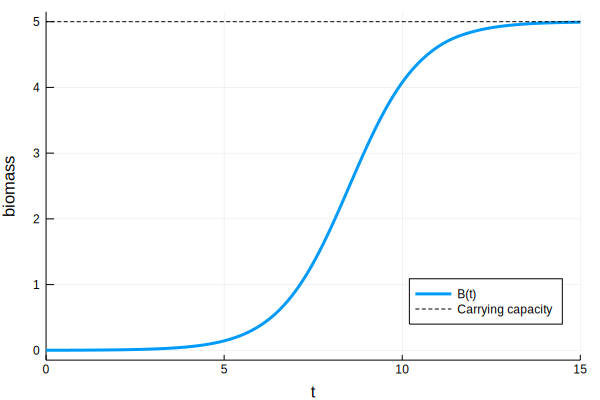

In [4]:
plot(sol, ylabel = "biomass", label = "B(t)", legend = :bottomright)
hline!([p[2]], linestyle = :dash, c = :black, label = "Carrying capacity")

### For multiple species

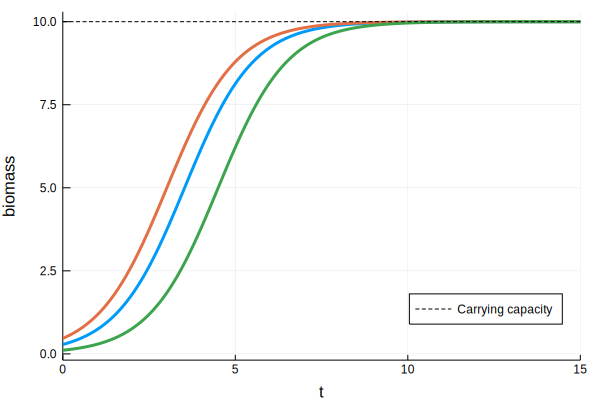

In [5]:
# For multiple species, we use matrix algebra, we have to directly declare the function
function LogisticGrowth(derivative, b, p, t)
    growth = p.r .* (1 .- (b ./ p.K)) .* b
    for i in eachindex(growth)
        derivative[i] = growth[i]
    end
    return growth
end
S = 3
p = (r = 1.0, K = 10.0)
b0 = rand(S)
tspan = (0.0, 15.0)

prob = ODEProblem(LogisticGrowth, b0, tspan, p)
s = solve(prob)
plot(s, ylabel = "biomass", label = "", leg = :bottomright)
hline!([p.K], linestyle = :dash, c = :black, label = "Carrying capacity")

### With R 

```R
# Install and load deSolve
install.packages("deSolve")
library(deSolve)

# Model specification and initialization
LogisticGrowth <- function(t, b0, p) {
                                      with(as.list(c(b0, p)), {
                                      dB <- r * (1 - (B / K)) * B
                                      list(dB)
                                      })
                                      }
p <- c(r = 1, K = 10) #model parameters
b0 <- c(B = 0.001) #variables initial values 
tspan <- seq(0, 15, by = 0.01) #time vector
out <- ode(y = b0, times = tspan, func = LogisticGrowth, parms = p)
plot(out[,1], out[,2], xlab = "t", ylab = "biomass", col = "blue", lwd = 1)
abline(h = 10, lty = 2)
```

![](logisticgrowth.png)

## Introducing inter- and intra-specific competition

$$
G(B_i) = 1 - \frac{\sum_{j}\alpha_{ij}B_j}{K}
$$

In [6]:
function competitive_growth(derivative, b, parameters, t)
    compete_with = sum(b' .* parameters[:α], dims = 2)
    G = 1 .- (compete_with ./ parameters[:K])
    growth = parameters[:r] .* G .* b
    for i in eachindex(growth)
        derivative[i] = growth[i]
    end
    return growth
end

competitive_growth (generic function with 1 method)

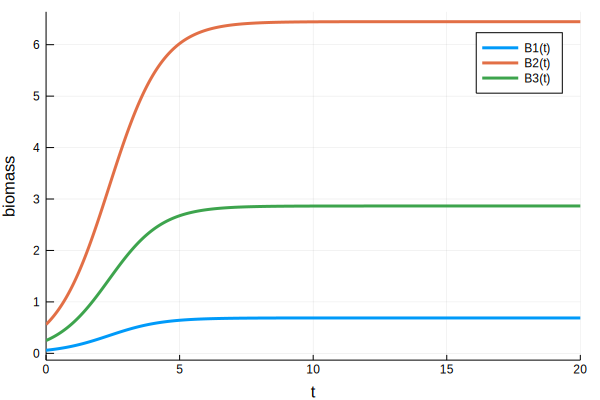

In [7]:
#competitive community of 3 producers
parameters = Dict(:α => [1.0 1.0 1.0 ; 1.0 1.0 1.0 ; 1.0 1.0 1.0],  #competition matrix
                  :K => 10.0,                                       #carrying capacity
                  :r => [1.0, 1.0, 1.0])                            #intrinsic growth rate

b = rand(3)
tspan = (0.0, 20.0)

prob = ODEProblem(competitive_growth, b, tspan, parameters)
sol = solve(prob)

plot(sol, labels = ["B1(t)" "B2(t)" "B3(t)"], ylabel = "biomass", legend = :best)

# Consumption 

## Holling, type II


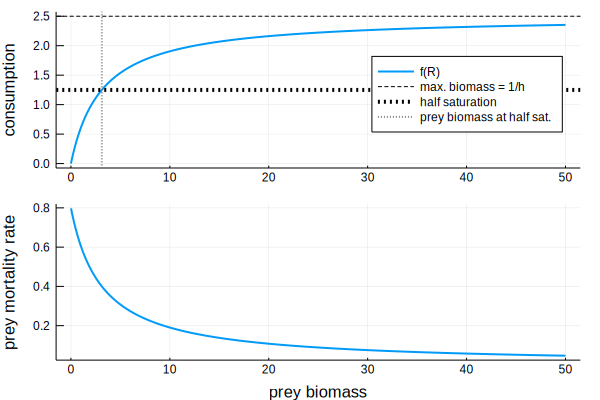

In [8]:
function HollingFR(p, R)
    Rq = R ^ (1+p.q)
    fr = (p.a * Rq) / (1 + (p.h * p.a * Rq))
    return fr
end

p = (a = 0.8, h = 0.4, q = 0.0)

C = float.([])
R = collect(0:0.01:50.0)
for i in R
    cons = HollingFR(p, i)
    append!(C, [cons])
end

p1 = plot(R, C, ylabel = "consumption", xlabel = "", label = "f(R)", leg = :bottomright, lw = 2)
hline!([1/p[:h]], linestyle = :dash, c = :black, label = "max. biomass = 1/h")
hline!([1/(2*p.h)], linestyle = :dot, c = :black, lw = 4, label = "half saturation")
vline!([1 / (p.a * p.h)] , linestyle = :dot, c = :grey, lw = 2, label = "prey biomass at half sat.")

p2 = plot(R, C ./ R, ylabel = "prey mortality rate", xlabel = "prey biomass", leg = false, lw = 2)
plot(p1, p2, layout = (2,1))

## Holling, type III: trophic control and escape from natural enemies

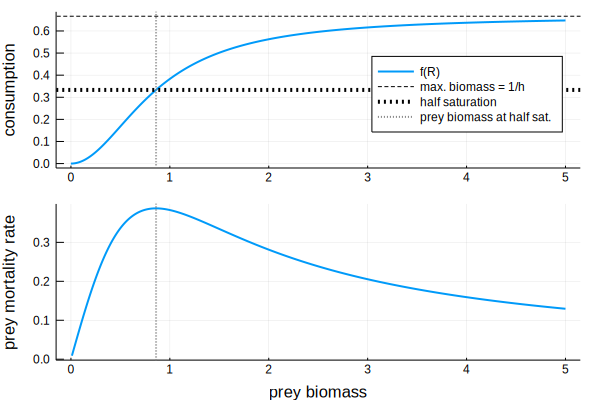

In [9]:
p = (a = 0.9, h = 1.5, q = 1.0)

C = []
R = 0:0.01:5.0
for i in R
    cons = HollingFR(p, i)
    append!(C, [cons])
end

p1 = plot(collect(R), float.(C), ylabel = "consumption", xlabel = "", label = "f(R)"
    , leg = :bottomright, lw = 2)

hline!([1/p.h], linestyle = :dash, c = :black, label = "max. biomass = 1/h")
hline!([1/(2*p.h)], linestyle = :dot, c = :black, lw = 4, label = "half saturation")
vline!([sqrt(1 / (p.a * p.h))] , linestyle = :dot, c = :grey, lw = 2, label = "prey biomass at half sat.")

p2 = plot(collect(R), float.(C) ./ collect(R), ylabel = "prey mortality rate", xlabel = "prey biomass"
    , leg = false, lw = 2)
vline!([sqrt(1 / (p.a * p.h))] , linestyle = :dot, c = :grey, lw = 2)
plot(p1, p2, layout = (2,1))

## Multi-species functional response

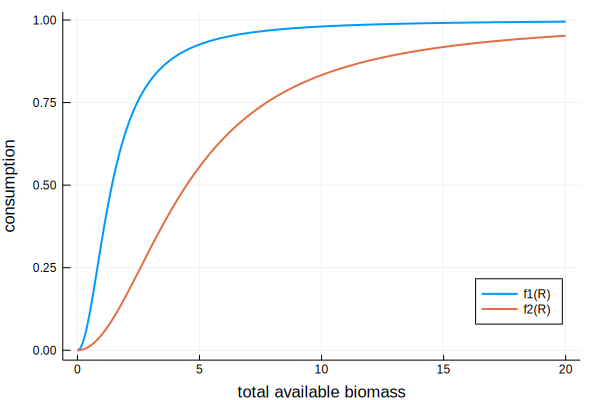

In [10]:
A = [0 0 0 0 ; 0 0 0 0 ; 1 1 0 0 ; 0 1 0 0]
is_consumer = sum(A, dims = 2) .!= 0
omega = (1 ./ sum(A, dims = 2)) .* is_consumer

p = (A = A, omega = omega, B0 = [0.0, 0.0, 0.5, 5.0], q = 1.0)

function FR(p, b)
    Bq = b .^ (1 + p.q)
    food_available = p.A .* Bq'
    preference = p.omega .* food_available
    total_food = sum(preference, dims = 2)
    denom = p.B0 .+ total_food
    fr = preference ./ denom
    return fr
end

C = []
R = collect(0:0.01:10.0)
for i in R
    b = repeat([i], 4)
    funcrep = FR(p, b)
    cons = sum(funcrep, dims = 2)
    append!(C, [hcat(cons)])
end
C = vcat(C'...)

plot(R .* 2, C[:,[3,4]], ylabel = "consumption", xlabel = "total available biomass"
    , label = ["f1(R)" "f2(R)"], leg = :bottomright, lw = 2)


# Model parameters 

## Using empirical data to parameterize the model 

In [11]:
using RCall, CSV
maxcons = CSV.read("data/maxconsdata.csv")

,x,y
,Float64⍰,Float64⍰
1,-1.82609,2.37225
2,-1.73913,2.4185
3,-1.65217,2.37885
4,-1.52174,2.28634
5,-1.47826,2.24009
6,-1.69565,2.1674
7,-1.04348,2.1674
8,-1.04348,2.07489
9,-1.41304,2.10793


In [12]:
@rput maxcons
R"lm_maxcons = lm(I(y-(-0.25)*x)~1, maxcons)"

RObject{VecSxp}

Call:
lm(formula = I(y - (-0.25) * x) ~ 1, data = maxcons)

Coefficients:
(Intercept)  
      1.854  



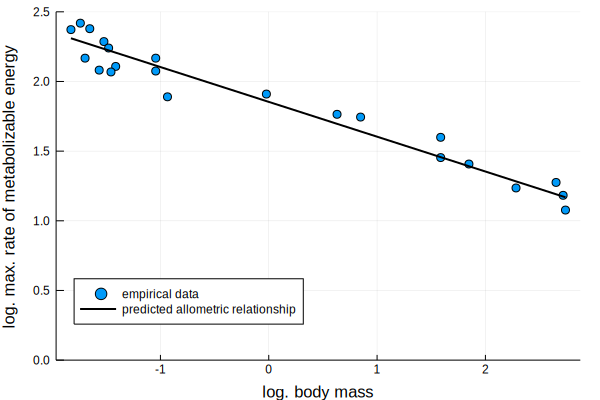

In [13]:
R"b = lm_maxcons$coefficients[1]"
@rget b
y2 = -0.25 .* maxcons[:x] .+ b
scatter(maxcons[:x], maxcons[:y], ylim = (0,2.5), label = "empirical data"
    , ylabel = "log. max. rate of metabolizable energy", xlabel = "log. body mass"
    , leg = :bottomleft)
plot!(maxcons[:x], y2, c = :black, lw = 2, label = "predicted allometric relationship")

## Sensitivity analysis

In [14]:
Pkg.add("JLD")
push!(LOAD_PATH, homedir())
import BioEnergeticFoodWebs

 Resolving package versions...
  Updating `~/.julia/Project.toml`
 [no changes]
  Updating `~/.julia/Manifest.toml`
 [no changes]


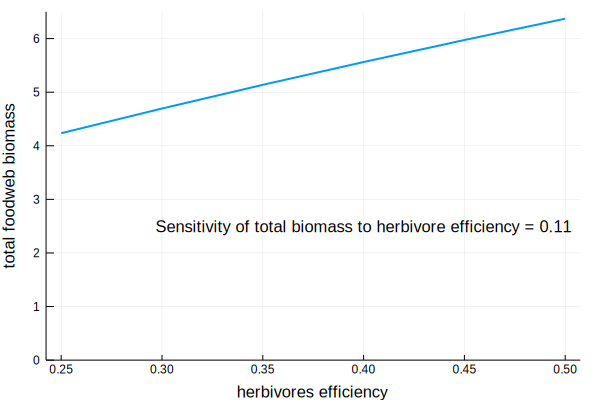

In [19]:
using BioEnergeticFoodWebs
import Random.seed!
seed!(22)
A = nichemodel(20,0.2)

#set parameters values (all else being equal)
eh_values = collect(0.25:0.05:0.5)
b0 = rand(20)
B = float.([]) #vector to store total biomass
for i in eh_values 
    global b0
    global B
    p = model_parameters(A, Z = 10.0, e_herbivore = i)
    s = simulate(p, b0, stop = 1000)
    btot = sum(population_biomass(s))
    append!(B, btot)
end

pI = (0.25 - 0.5) / 0.25 * 100
pO = (B[1] - B[2]) / B[1] * 100
S = round(pO / pI, digits = 2)

plot(eh_values, B, lw = 2, xlabel = "herbivores efficiency", ylabel = "total foodweb biomass", leg = false, ylim = (0,6.5))
annotate!([0.4], [2.5], text("Sensitivity of total biomass to herbivore efficiency = $S", 11))

# Application: robustness analysis

In [27]:
#load or simulate a food web
A = Matrix(CSV.read("data/Wood2015_foodwebdata.csv", header = false))
A = convert(Array{Int64, 2}, A)

#set the model parameters 
p = model_parameters(
    A,                           # matrix
    Z = 10.0,                    # consumer/resource body-mass ratio
    h = 2.0                      # hill exponent (=1+q)
    )
#set initial biomass
S = size(A,1)
b0 = rand(S)
#run the model for 3000 timesteps to remove potential transient dynamics 
s = simulate(p, b0, stop = 3000)

#set extinction sequence (top-down)
spkeep = deleteat!(collect(1:1:S), p[:extinctions])
spkeep_bool = map(x -> x in spkeep, collect(1:1:S))
cons_notextinct = .!p[:is_producer] .& spkeep_bool
TR_sorted = sortperm(p[:trophic_rank], rev = true)
idx_sorted = cons_notextinct[TR_sorted]
seq_TD = TR_sorted[idx_sorted]

sec_extinctions = []
prim_extinctions = []

for i in eachindex(seq_TD)
    global p
    global spkeep_bool
    global seq_TD
    
    primext = seq_TD[1:i]
    append!(prim_extinctions, [primext])

    Beq_prev = s[:B][end,:] #new initial biomass is equilibrium biomass from previous simulation
    Beq_prev[primext] .= 0.0 #remove species
    
    s_new = simulate(p, Beq_prev, stop = 3000) #simulate
    
    #find secondary extinctions 
    extinct = s_new[:B][end,:] .< 10e-6
    sec_extinct = findall(extinct .& spkeep_bool)
    sec_keep = map(x -> x ∈ primext, sec_extinct)
    global sec_extinct = sec_extinct[.!sec_keep] 
    
    #record extinctions
    append!(sec_extinctions, [sec_extinct])
end

S50 = length(spkeep)/2
Next = length.(prim_extinctions) .+ length.(sec_extinctions)
idS50 = findfirst(Next .>= S50)

R50 = round(length(prim_extinctions[idS50]) / length(spkeep), digits = 2)

0.42